In [5]:
import numpy as np
from pathlib import Path

S0, r, sigma = 100.0, 0.02, 0.05
T            = 1.0
dt           = 1/504
n_paths      = 50_000
t_list       = np.round(np.linspace(0.05, 1.0, 30), 3)
S_min, S_max, dS = 0.0, 200.0, 0.2

def sample_gbm_paths(file_path="gbm_samples_mc.npz"):
    fp = Path(file_path)
    if fp.exists():
        d = np.load(fp)
        return d["times"], d["paths"]

    n_steps = int(T/dt)+1
    times   = np.linspace(0, T, n_steps, dtype=np.float32)

    dW   = np.random.normal(scale=np.sqrt(dt),
                            size=(n_paths, n_steps-1)).astype(np.float32)
    W    = np.concatenate([np.zeros((n_paths, 1), dtype=np.float32),
                           np.cumsum(dW, axis=1)], axis=1)
    drift = (r-0.5*sigma**2)*times
    paths = S0*np.exp(drift + sigma*W)

    np.savez_compressed(fp, times=times, paths=paths)
    return times, paths

times, paths = sample_gbm_paths()

S_edges   = np.arange(S_min, S_max + dS, dS, dtype=np.float32)
S_centers = 0.5*(S_edges[:-1] + S_edges[1:])
bin_w     = float(dS)

density_matrix = np.empty((len(t_list), len(S_centers)), dtype=np.float32)
for i, t in enumerate(t_list):
    idx = np.abs(times - t).argmin()
    S_slice = paths[:, idx]
    counts, _ = np.histogram(S_slice, bins=S_edges)
    density_matrix[i] = counts / (n_paths * bin_w)

np.savez_compressed(
    "gbm_density_hist.npz",
    t_list   = t_list.astype(np.float32),
    S_centers= S_centers,
    density  = density_matrix
)
print("density_matrix shape:", density_matrix.shape)   # (20, N_S)


density_matrix shape: (30, 1000)


In [ ]:
import numpy as np, torch, torch.nn as nn, torch.optim as optim
from pathlib import Path
import tqdm, math, random

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(20240617)
np.random.seed(20240617)
random.seed(20240617)

S0, r, sigma = 100.0, 0.02, 0.05
DT          = 1/504
HIDDEN      = 64
N_EPOCH_REF = 2000
N_EPOCH_FIN = 1000
LR          = 3e-3
W_PDE       = 5.0
W_REF       = 1.0

d       = np.load("gbm_density_hist.npz")
t_list  = torch.tensor(d["t_list"],    dtype=torch.float32)
S_grid  = torch.tensor(d["S_centers"], dtype=torch.float32)
pdf     = torch.tensor(d["density" ],  dtype=torch.float32)
bin_w   = float(S_grid[1]-S_grid[0])

N_t, N_S = pdf.shape
assert N_t == len(t_list)

class SliceMLP(nn.Module):
    def __init__(self, hidden=HIDDEN, n_layers=3, t_value=0.0, eps=1e-8):
        super().__init__()
        self.eps = eps
        self.t_const = nn.Parameter(torch.tensor([[t_value]]),
                                    requires_grad=False)

        layers = [nn.Linear(2, hidden), nn.Tanh()]
        for _ in range(n_layers - 1):
            layers += [nn.Linear(hidden, hidden), nn.Tanh()]
        self.body = nn.Sequential(*layers)
        self.out  = nn.Linear(hidden, 1)

        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, S_in):
        t_in = self.t_const.expand_as(S_in)
        h    = self.body(torch.cat([t_in, S_in], dim=1))
        return torch.nn.functional.softplus(self.out(h)) + self.eps

    def pdf(self, S_query):
        return self.forward(S_query)

models = nn.ModuleList([SliceMLP(t_value=float(t)) for t in t_list]).to(device)

def mse_ref(model, S_batch, p_target):
    p_pred = model.pdf(S_batch)
    return (p_pred - p_target).pow(2).mean()

def fp_residual(net, X, mu=r, vol=sigma):
    X = X.clone().detach().requires_grad_(True)
    t, S = X[:, :1], X[:, 1:2]

    p = net(X)

    grad_p = torch.autograd.grad(
        p, X, torch.ones_like(p), create_graph=True
    )[0]
    p_t = grad_p[:, :1]

    flux1   = mu * S * p
    grad_f1 = torch.autograd.grad(
        flux1, X, torch.ones_like(flux1), create_graph=True
    )[0]
    flux1_S = grad_f1[:, 1:2]

    flux2      = 0.5 * vol**2 * S**2 * p
    grad_f2    = torch.autograd.grad(
        flux2, X, torch.ones_like(flux2), create_graph=True
    )[0]
    flux2_S    = grad_f2[:, 1:2]
    grad_f2_S  = torch.autograd.grad(
        flux2_S, X, torch.ones_like(flux2_S), create_graph=True
    )[0]
    flux2_SS = grad_f2_S[:, 1:2]

    return p_t + flux1_S - flux2_SS

optimizer = optim.Adam(models.parameters(), lr=LR)

def train_ref_only():
    loader_S = S_grid.unsqueeze(1).to(device)

    for i in range(N_t):
        model   = models[i]
        p_target= pdf[i].unsqueeze(1).to(device)

        optim_i = optim.Adam(model.parameters(), lr=LR)

        for epoch in range(N_EPOCH_REF):
            loss = mse_ref(model, loader_S, p_target)
            optim_i.zero_grad()
            loss.backward()
            optim_i.step()

            if (epoch+1) % 500 == 0:
                tqdm.tqdm.write(f"[Ref-chain] slice {i}/{N_t-1} "
                                f"epoch {epoch+1}, loss={loss.item():.4e}")

        if i < N_t-1:
            models[i+1].load_state_dict(model.state_dict())

def train_with_pde():
    loader_S = S_grid.unsqueeze(1).to(device)
    dt = float(t_list[1]-t_list[0])
    for epoch in tqdm.trange(N_EPOCH_FIN, desc="Stage-2 PDE"):
        total_loss = 0.
        for i in range(N_t-1):
            mdl_i, mdl_ip1 = models[i], models[i+1]

            p_trg_i   = pdf[i  ].unsqueeze(1).to(device)
            p_trg_ip1 = pdf[i+1].unsqueeze(1).to(device)
            ref_loss  = mse_ref(mdl_i, loader_S, p_trg_i) \
                       +mse_ref(mdl_ip1,loader_S, p_trg_ip1)

            with torch.enable_grad():
                S_batch = loader_S
                def net_pair(X):
                    S_in = X[:,1:2]
                    p_i   = mdl_i.pdf(S_in)
                    p_ip1 = mdl_ip1.pdf(S_in)
                    t0 = float(t_list[i])
                    return p_i + (X[:,0:1]-t0)*(p_ip1-p_i)/dt

                t_tensor = torch.full_like(S_batch, float(t_list[i]))
                X_in     = torch.cat([t_tensor, S_batch], dim=1).detach()
                X_in.requires_grad_(True)

                pde_res  = fp_residual(net_pair, X_in, mu=r, vol=sigma)
                pde_loss = (pde_res**2).mean()

            total_loss += W_REF*ref_loss + W_PDE*pde_loss

        total_loss /= (N_t-1)
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        if (epoch+1) % 500 == 0:
            tqdm.tqdm.write(f"[PDE] epoch {epoch+1}, loss={total_loss.item():.4e}")

if __name__ == "__main__":
    print(">> Stage-1: only Ref-loss")
    train_ref_only()
    print(">> Stage-2: add PDE-loss (finite-diff ∂t)")
    train_with_pde()

    out_dir = Path("slice_mlps")
    out_dir.mkdir(exist_ok=True)
    for t, mdl in zip(t_list, models):
        torch.save(mdl.state_dict(), out_dir / f"mlp_t{float(t):.3f}.pt")
    print("All slice-MLPs saved in ./slice_mlps/")


>> Stage-1: only Ref-loss
[Ref-chain] slice 0/29 epoch 500, loss=1.2522e-03
[Ref-chain] slice 0/29 epoch 1000, loss=1.2445e-03
[Ref-chain] slice 0/29 epoch 1500, loss=1.2426e-03
[Ref-chain] slice 0/29 epoch 2000, loss=1.2411e-03
[Ref-chain] slice 1/29 epoch 500, loss=9.5765e-04
[Ref-chain] slice 1/29 epoch 1000, loss=9.4615e-04
[Ref-chain] slice 1/29 epoch 1500, loss=9.6137e-04
[Ref-chain] slice 1/29 epoch 2000, loss=9.4668e-04
[Ref-chain] slice 2/29 epoch 500, loss=6.3470e-04
[Ref-chain] slice 2/29 epoch 1000, loss=7.7565e-04
[Ref-chain] slice 2/29 epoch 1500, loss=8.2645e-04
[Ref-chain] slice 2/29 epoch 2000, loss=7.9001e-04
[Ref-chain] slice 3/29 epoch 500, loss=6.9533e-04
[Ref-chain] slice 3/29 epoch 1000, loss=6.9703e-04
[Ref-chain] slice 3/29 epoch 1500, loss=7.2503e-04
[Ref-chain] slice 3/29 epoch 2000, loss=6.8941e-04
[Ref-chain] slice 4/29 epoch 500, loss=3.4124e-04
[Ref-chain] slice 4/29 epoch 1000, loss=5.3477e-06
[Ref-chain] slice 4/29 epoch 1500, loss=3.9973e-05
[Ref-chain

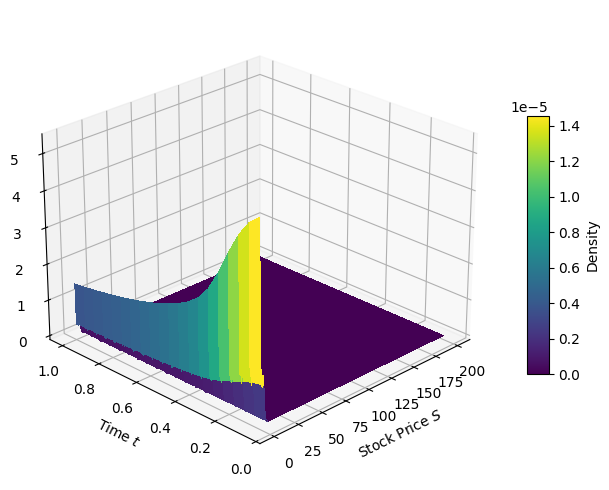

In [5]:
import numpy as np, torch, matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from pathlib import Path
import math

device = "cuda" if torch.cuda.is_available() else "cpu"

d = np.load("gbm_density_hist.npz")
t_list  = torch.tensor(d["t_list"],    dtype=torch.float32)
S_grid  = torch.tensor(d["S_centers"], dtype=torch.float32)

K_GMM, HIDDEN = 5, 64

class SliceMDN(torch.nn.Module):
    def __init__(self, K=K_GMM, hidden=HIDDEN, t_value=0.0):
        super().__init__()
        self.t_const = torch.nn.Parameter(torch.tensor([[t_value]]),
                                          requires_grad=False)
        self.fc1 = torch.nn.Linear(2, hidden)
        self.fc2 = torch.nn.Linear(hidden, hidden)
        self.mu     = torch.nn.Linear(hidden, K)
        self.logsig = torch.nn.Linear(hidden, K)
        self.logpi  = torch.nn.Linear(hidden, K)

    def forward(self, S_in):
        t_in = self.t_const.expand_as(S_in)
        x    = torch.cat([t_in, S_in], dim=1)
        x    = torch.tanh(self.fc1(x))
        x    = torch.tanh(self.fc2(x))
        mu, logsig, logpi = self.mu(x), self.logsig(x), self.logpi(x)
        sigma = torch.exp(logsig.clamp(-7, 4))
        pi    = torch.softmax(logpi, dim=1)
        return mu, sigma, pi

    def pdf(self, S_query):
        mu, sigma, pi = self.forward(S_query)
        gauss = torch.exp(-0.5*((S_query-mu)/sigma)**2) / (
                   sigma*math.sqrt(2*math.pi))
        return (pi*gauss).sum(dim=1, keepdim=True)

densities = []
for t in t_list:
    mdl = SliceMDN(t_value=float(t)).to(device)
    ckpt = Path(f"slice_mdns/mdn_t{float(t):.3f}.pt")
    mdl.load_state_dict(torch.load(ckpt, map_location=device))
    with torch.no_grad():
        p = mdl.pdf(S_grid.unsqueeze(1).to(device))
    densities.append(p.squeeze(1).cpu())

density_mat = torch.stack(densities, dim=0).numpy()

S_mesh, T_mesh = np.meshgrid(S_grid.numpy(), t_list.numpy())

fig = plt.figure(figsize=(8,5))
ax  = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(S_mesh, T_mesh, density_mat,
                       cmap='viridis', linewidth=0, antialiased=False)
ax.set_xlabel("Stock Price $S$")
ax.set_ylabel("Time $t$")
ax.set_zlabel(r"Density $p(t,S)$")
fig.colorbar(surf, shrink=0.55, aspect=12, label="Density")
ax.view_init(elev=25, azim=-135)
plt.tight_layout()
plt.show()

NameError: name 'XY_all' is not defined